In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import cartopy
import xarray as xr
import argopy 

In [2]:
BOX=[80, 95, 5, 20, 0, 2000, '2023-09', '2024-08']# Bay of Bengal

ArgoSet = argopy.DataFetcher().region(BOX) 
df_raw = ArgoSet.data.argo.point2profile().to_dataframe()

# Remove rows where temp is None
df = df_raw.dropna(subset=['TEMP', 'PRES'])

# Define the variables to work with:
temp = np.array(df['TEMP'])
pressure = np.array(df['PRES'])
sal = np.array(df['PSAL'])
lat = np.array(df['LATITUDE'])
lon = np.array(df['LONGITUDE'])
time = np.array(df['TIME'])

/var/folders/2w/tdn42d6s2lx6l_8md1rzw46r0000gn/T/ipykernel_6596/425214074.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


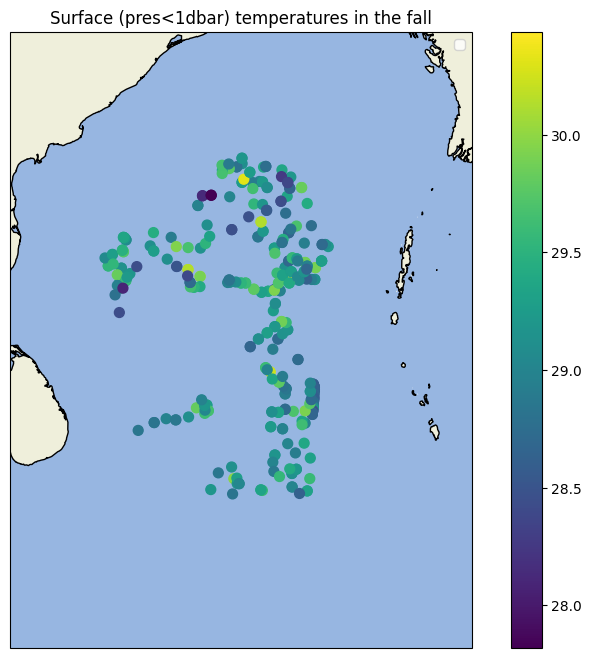

In [35]:
#Select data for each season
fall = df.loc[df['PRES']<1 & df['TIME'].between('2023-09-01','2024-01-01')]
winter = df.loc[df['PRES']<1 & df['TIME'].between('2023-01-01','2024-04-01')]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': cartopy.crs.PlateCarree()})

# Add features
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)

# Plot your data
scatter = ax.scatter(fall['LONGITUDE'],fall['LATITUDE'], transform=cartopy.crs.PlateCarree(), marker='o', c=fall['TEMP'], s=50)
plt.colorbar(scatter)
plt.xlim(80,95)
plt.ylim(0,20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface (pres<1dbar) temperatures in the fall')
plt.show()